# Memory Based Collaborative Filtering

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [2]:
USERS: int = 10
ITEMS: int = 15

MIN_RATING: int = 0
MAX_RATING: int = 5
    
MIN_SHARED_RATINGS: int = 3

In [3]:
ratings: np.array = MAX_RATING * np.random.randn(USERS, ITEMS)
ratings[ratings < MIN_RATING] = np.nan
ratings[ratings > MAX_RATING] = MAX_RATING
ratings = np.floor(ratings)
print(ratings)

[[nan  1.  1.  2.  5. nan nan  0. nan nan  5. nan nan  5. nan]
 [ 3. nan  0. nan  0.  5. nan  5.  3.  1.  1. nan nan nan  0.]
 [nan  2.  5.  1. nan nan  1.  0. nan nan nan nan  3. nan nan]
 [ 1.  0.  2. nan  4. nan  1. nan  3.  0.  5.  0.  5.  2.  3.]
 [ 2. nan nan nan nan  4. nan nan nan nan  2.  4.  4. nan nan]
 [ 1. nan  5. nan  3.  3.  1.  5. nan  4.  5.  4. nan nan nan]
 [nan  0. nan  5. nan nan nan nan  0. nan nan nan  5.  5.  5.]
 [nan  0.  3. nan  1.  5. nan  0.  1. nan nan nan  1.  2. nan]
 [nan nan  1. nan nan nan nan  5. nan nan  3.  0. nan  5. nan]
 [ 3.  0.  2. nan  3. nan nan nan nan  3.  3. nan nan nan  5.]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [4]:
def get_normalized(matrix: np.array) -> np.array:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    averages: np.array = np.nansum(matrix, axis=1) / sample_size
    averages = averages.reshape(averages.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - averages, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    standard: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - averages) / standard
    return normalized

ORIGINAL [[-0.74543419  3.04465272  2.94712605  4.50179878  4.9756789   4.99796398
   6.44437317  6.29794195  7.81973145  9.62159549]
 [19.7699068  24.87791971 33.56888474 39.50447626 46.13023356 55.47876172
  59.02872353 65.25585314 74.10346834 79.6624684 ]]
NORMALIZED [[-2.10324351 -0.71351066 -0.74927132 -0.17921058 -0.00545024  0.00272116
   0.53308429  0.47939151  1.03739478  1.69809458]
 [-1.54868147 -1.28471183 -0.83558399 -0.52884711 -0.18644416  0.29666495
   0.4801183   0.80192115  1.2591443   1.54641985]]


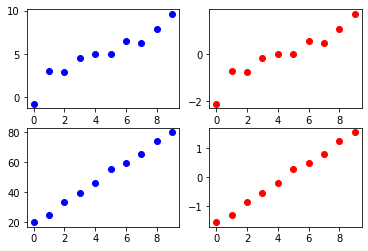

In [5]:
x: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
y = get_normalized(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [6]:
def get_cosine(X: np.array, Y: np.array) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(MIN_SHARED_RATINGS, np.count_nonzero(union)) / MIN_SHARED_RATINGS
    return discount * np.sum(X[union] * Y[union]) / \
        (math.max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         np.sqrt(np.sum(np.power(Y[union], 2))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


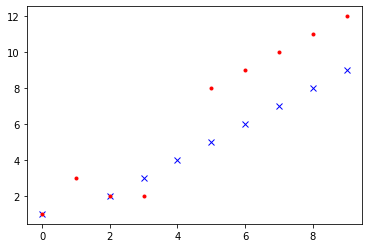

In [7]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


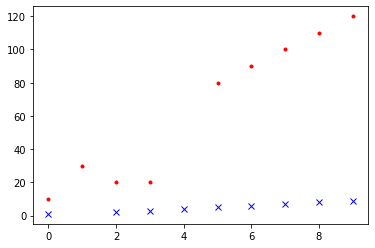

In [8]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


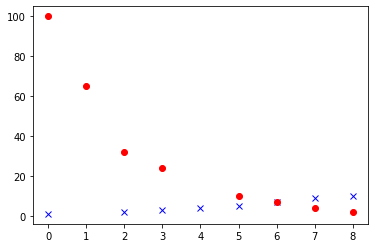

In [9]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [12]:
def get_similarity(matrix: np.array) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    correlations: np.array = np.stack([
        [
            0 if i >= j else get_cosine(x, y)
            for j, y in enumerate(matrix)
        ]
        for i, x in enumerate(matrix)
    ])
    return correlations + correlations.T

In [13]:
X: np.array = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
S: np.array = get_similarity(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.95941195]
 [0.97463185 0.         0.99819089]
 [0.95941195 0.99819089 0.        ]]


## Top K-Similar Rows

- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In [33]:
def get_closest(similar: np.array, k: int = 5) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - k:]

In [34]:
X: np.array = np.array([ [0, 2, 3, 1], [8, 0, 6, 1], [7, 6, 0, 2], [2, 3, 1, 0] ])
S: np.array = get_closest(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


## User-Based Collaborative Filtering

#### User-User Matrix

In [15]:
print(ratings)

[[nan  1.  1.  2.  5. nan nan  0. nan nan  5. nan nan  5. nan]
 [ 3. nan  0. nan  0.  5. nan  5.  3.  1.  1. nan nan nan  0.]
 [nan  2.  5.  1. nan nan  1.  0. nan nan nan nan  3. nan nan]
 [ 1.  0.  2. nan  4. nan  1. nan  3.  0.  5.  0.  5.  2.  3.]
 [ 2. nan nan nan nan  4. nan nan nan nan  2.  4.  4. nan nan]
 [ 1. nan  5. nan  3.  3.  1.  5. nan  4.  5.  4. nan nan nan]
 [nan  0. nan  5. nan nan nan nan  0. nan nan nan  5.  5.  5.]
 [nan  0.  3. nan  1.  5. nan  0.  1. nan nan nan  1.  2. nan]
 [nan nan  1. nan nan nan nan  5. nan nan  3.  0. nan  5. nan]
 [ 3.  0.  2. nan  3. nan nan nan nan  3.  3. nan nan nan  5.]]


#### User-User Normalized Matrix

In [16]:
normalized: np.array = get_normalized(ratings)
print(normalized)

[[        nan -0.83607962 -0.83607962 -0.34836651  1.11477282         nan
          nan -1.32379273         nan         nan  1.11477282         nan
          nan  1.11477282         nan]
 [ 0.51449576         nan -1.02899151         nan -1.02899151  1.54348727
          nan  1.54348727  0.51449576 -0.51449576 -0.51449576         nan
          nan         nan -1.02899151]
 [        nan  0.          1.83711731 -0.61237244         nan         nan
  -0.61237244 -1.22474487         nan         nan         nan         nan
   0.61237244         nan         nan]
 [-0.65850461 -1.22293713 -0.09407209         nan  1.03479296         nan
  -0.65850461         nan  0.47036043 -1.22293713  1.59922548 -1.22293713
   1.59922548 -0.09407209  0.47036043]
 [-1.22474487         nan         nan         nan         nan  0.81649658
          nan         nan         nan         nan -1.22474487  0.81649658
   0.81649658         nan         nan]
 [-1.6307485          nan  1.03774904         nan -0.29649973 -0.

#### User-User Correlation Matrix

In [17]:
similar: np.array = get_similarity(normalized)
print(similar)

[[ 0.         -0.59867109  0.07206163  0.76600433 -0.33333333 -0.34960016
   0.69310328  0.31590633  0.15852889  0.62697404]
 [-0.59867109  0.         -0.61538462 -0.3453883   0.38569461 -0.17132302
  -0.53333333  0.14715305  0.93790309 -0.41950214]
 [ 0.07206163 -0.61538462  0.          0.28092546  0.33333333  0.32507714
   0.          0.65600487 -0.63746664 -0.1696622 ]
 [ 0.76600433 -0.3453883   0.28092546  0.         -0.15292535  0.32574785
   0.49447745 -0.02100525  0.45983377  0.4728968 ]
 [-0.33333333  0.38569461  0.33333333 -0.15292535  0.          0.18989741
   0.33333333  0.37768588 -0.40838111 -0.66666667]
 [-0.34960016 -0.17132302  0.32507714  0.32574785  0.18989741  0.
   0.         -0.17435115 -0.05661628 -0.43321421]
 [ 0.69310328 -0.53333333  0.          0.49447745  0.33333333  0.
   0.          0.71205164  0.33333333  0.64814909]
 [ 0.31590633  0.14715305  0.65600487 -0.02100525  0.37768588 -0.17435115
   0.71205164  0.         -0.67252654  0.51925873]
 [ 0.15852889  0

## Memory-Based Collaborative Filtering

#### Item-Item Matrix

In [35]:
print(ratings.T)

[[nan  3. nan  1.  2.  1. nan nan nan  3.]
 [ 1. nan  2.  0. nan nan  0.  0. nan  0.]
 [ 1.  0.  5.  2. nan  5. nan  3.  1.  2.]
 [ 2. nan  1. nan nan nan  5. nan nan nan]
 [ 5.  0. nan  4. nan  3. nan  1. nan  3.]
 [nan  5. nan nan  4.  3. nan  5. nan nan]
 [nan nan  1.  1. nan  1. nan nan nan nan]
 [ 0.  5.  0. nan nan  5. nan  0.  5. nan]
 [nan  3. nan  3. nan nan  0.  1. nan nan]
 [nan  1. nan  0. nan  4. nan nan nan  3.]
 [ 5.  1. nan  5.  2.  5. nan nan  3.  3.]
 [nan nan nan  0.  4.  4. nan nan  0. nan]
 [nan nan  3.  5.  4. nan  5.  1. nan nan]
 [ 5. nan nan  2. nan nan  5.  2.  5. nan]
 [nan  0. nan  3. nan nan  5. nan nan  5.]]


#### Item-Item Normalized Matrix

In [38]:
normalized: np.array = get_normalized(ratings.T)
print(normalized)

[[        nan  1.11803399         nan -1.11803399  0.         -1.11803399
          nan         nan         nan  1.11803399]
 [ 0.65465367         nan  1.96396101 -0.65465367         nan         nan
  -0.65465367 -0.65465367         nan -0.65465367]
 [-0.79593207 -1.37479175  1.51950667 -0.21707238         nan  1.51950667
          nan  0.3617873  -0.79593207 -0.21707238]
 [-0.39223227         nan -0.98058068         nan         nan         nan
   1.37281295         nan         nan         nan]
 [ 1.37281295 -1.56892908         nan  0.78446454         nan  0.19611614
          nan -0.98058068         nan  0.19611614]
 [        nan  0.90453403         nan         nan -0.30151134 -1.50755672
          nan  0.90453403         nan         nan]
 [        nan         nan  0.          0.                 nan  0.
          nan         nan         nan         nan]
 [-1.          1.         -1.                 nan         nan  1.
          nan -1.          1.                 nan]
 [        nan  0

#### Item-Item Correlation Matrix

In [55]:
similar: np.array = get_similarity(normalized)
print(similar)

[nan nan  0.  0. nan  0. nan nan nan nan]
111 2 [False False  True False False  True False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 1 [False False False  True False False False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 2 [False False False  True False  True False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 2 [False False False  True False  True False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 2 [False False False  True False  True False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 2 [False False  True  True False False False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 1 [False False False  True False False False False False False] 0.0
[nan nan  0.  0. nan  0. nan nan nan nan]
111 1 [False False False  True False False False False False False] 0.0
[[ 0.          0.         -0.6984303   0.         -0.66258916  0.95618289
   0.         